In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.benchmarks.ts_benchmarks import IndependentAR1, CorrelatedAR1, NonlinearLag1, power_curve

Simple test that everything works.

In [2]:
n = 40
X = np.random.normal(0.0, 1.0, n).reshape(n,1)
Y = np.random.normal(0.0, 1.0, n).reshape(n,1)

max_lag = 0

dcorrx = DCorrX(max_lag = max_lag)
p_value, dcorrx_metadata = dcorrx.p_value(X, Y, is_fast = True)
print("The p_value for DCorrX is: %f" % p_value)

mgcx = MGCX(max_lag = max_lag)
p_value, mgcx_metadata = mgcx.p_value(X, Y, is_fast = True)
print("The p_value for MGCX is: %f" % p_value)

The p_value for DCorrX is: 0.156130
The p_value for MGCX is: 0.551361


(array([39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.05143221, 0.10286442, 0.15429663, 0.20572884,
        0.25716105, 0.30859326, 0.36002547, 0.41145768, 0.46288989,
        0.5143221 ]),
 <a list of 10 Patch objects>)

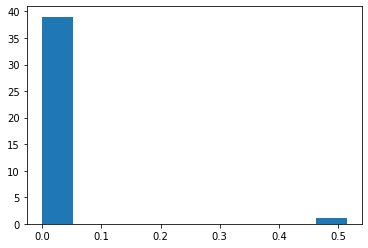

In [3]:
null_dist = mgcx_metadata['null_distribution']
plt.hist(null_dist)

Experiments.

In [4]:
max_lag = 1
num_sims = 40
alpha = 0.05
sample_sizes = range(20, 90, 10)

dcorrx = DCorrX(max_lag = max_lag)
mgcx = MGCX(max_lag = max_lag)

tests = [
    {
        'name' : 'DCorr-X',
        'filename' : 'dcorrx',
        'is_fast' : False,
        'object' : dcorrx,
        'color' : 'red',
    },
    {
        'name' : 'Fast DCorr-X',
        'filename' : 'fast_dcorrx',
        'is_fast' : True,
        'object' : dcorrx,
        'color' : 'blue',
    },
#     {
#         'name' : 'MGC-X',
#         'filename' : 'mgcx',
#         'is_fast' : False,
#         'object' : mgcx,
#         'color' : 'orange',
#     },
    {
        'name' : 'Fast MGC-X',
        'filename' : 'fast_mgcx',
        'is_fast' : True,
        'object' : mgcx,
        'color' : 'green',
    },
]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done  32 out of  40 | elapsed:    7.3s remaining:    1.8s
[Parallel(n_jobs=-2)]: Done  37 out of  40 | elapsed:    8.6s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:    8.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-2)]: Done  32 out of  40 | elapsed:    9.2s remaining:    2.3s
[Parallel(n_jobs=-2)]: Done  37 out of

[Parallel(n_jobs=-2)]: Done  32 out of  40 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1009s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  22 out of  40 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done  32 out of  40 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:    0.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1327s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  22 out of  40 | elap

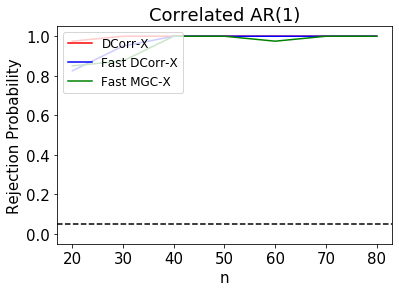

In [5]:
process = CorrelatedAR1()
power_curve(tests, process, num_sims, alpha, sample_sizes)